<a href="https://colab.research.google.com/github/DanteNoguez/modelos/blob/main/notebooks/ViT_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!nvidia-smi

Tue Sep 13 17:46:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    34W / 250W |    913MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [ ]:
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fa3dd7c4fd0>,
 ['pizza', 'steak', 'sushi'])

### Comenzamos a definir las variables del paper:

$X$ = Imagen | $x \in \mathbb{R}^{H \times W  \times C}$ \\
$H, W, C$ = Height, Width, Channels (colors), \\
$P$ = Patches (parches, tokens, pedazos de imagen; $P, P$ es la resolución de cada parche) \\
$N$ = Número de parches | $H \times W / P^2$ \\

In [ ]:
X = torch.randn(224, 224, 3) #imagen x

H = 224 #height
W = 224 #width
C = 3 #colores

P = 16 #tamaño del patch, ViT-Base/16

N = (H * W / P**2) #número de patches según la fórmula N=H*W/P**2
N

196.0

$D$ = Dimensión de los parches | $P^2  \cdot C$ \\
$\mathbf{x}_p$ = Dimensiones de la imagen después de ser parchada (patched) | $\mathbf{x}_p \in \mathbb{R}^{N \times (P^2  \cdot C)}$ (*i. e.*, número de parches por dimensiones de los parches).


In [ ]:
D = (P**2 * C) #dimensión de los parches después del embed
Xp = (N, D) # nuevas dimensiones de la imagen parchada
Xp

(196.0, 768)

In [ ]:
# Verificar que las dimensiones de la imagen original 
# y la imagen parchada sean equivalentes:

a = H*W*C
b = N*D

a, b

(150528, 150528.0)

In [ ]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[1], label_batch[1]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

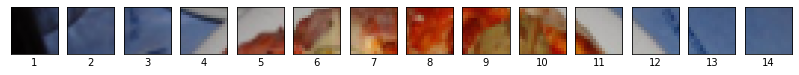

In [ ]:
image_permuted = image.permute(1, 2, 0)

# Create a series of subplots
fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

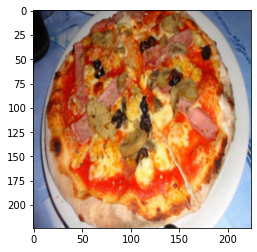

In [ ]:
plt.imshow(image_permuted)

In [ ]:
conv2d = nn.Conv2d(in_channels=C, out_channels=D, kernel_size=P, stride=P, padding=0)

In [ ]:
conv = conv2d(image.unsqueeze(0))
conv.shape

torch.Size([1, 768, 14, 14])

In [ ]:
flatten = nn.Flatten(start_dim=2, end_dim=3)

flat = flatten(conv)

flat.permute(0,2,1).shape

torch.Size([1, 196, 768])

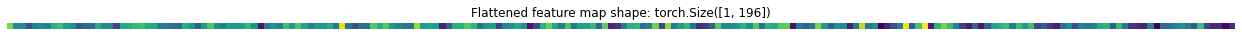

In [ ]:
flat_map = flat.permute(0,2,1)[:, :, 0]

plt.figure(figsize=(22,22))
plt.imshow(flat_map.detach().numpy())
plt.title(f'Flattened feature map shape: {flat_map.shape}')
plt.axis(False);

Eq. 1:
\begin{aligned}
\mathbf{z}_0 &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}

"As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding projection $\mathbf{E}$ (Eq. 1) is applied to patches extracted from a CNN feature map".

$\mathbf{E}$ = *Embedding* (incrustación, inmersión, colocamiento de los parches en una nueva dimensión) \\
$\mathbf{z}_0$ = output de la primera layer (*i. e., embedding*) \\
$\mathbf{x}_p^N$ = Posición de cada parche de la inmersión (*embedding*)

In [ ]:
# Para facilitar el proceso de parchear la imagen, utilizamos una CNN con una layer de Conv2d y una de Flatten, consiguiendo así la imagen con las dimensiones deseadas:

class PatchEmbedding(nn.Module):
  def __init__(self, in_channels: int=C, patch_size: int=P, embedding_dim: int=D):
    super().__init__()
    self.patch_size = patch_size
    self.patcher = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size, padding=0)
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)
  
  def forward(self, x):
    resolution = x.shape[-1]
    assert resolution % patch_size == 0

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0, 2, 1)

In [ ]:
patchify = PatchEmbedding()

print(image.unsqueeze(0).shape)
embedded_image = patchify(image.unsqueeze(0))
print(embedded_image.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 196, 768])


In [ ]:
summary(PatchEmbedding(),
        input_size=image.unsqueeze(0).shape, # try swapping this for "random_input_image_error" 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [ ]:
print(embedded_image)
print(embedded_image.shape)
print(embedded_image.size(dim=1))

tensor([[[ 0.1008,  0.0380, -0.0470,  ...,  0.0041,  0.0023,  0.0896],
         [ 0.2432,  0.2987, -0.1254,  ...,  0.2290,  0.0217,  0.2726],
         [ 0.2824,  0.3224, -0.1931,  ...,  0.3248,  0.0251,  0.3053],
         ...,
         [ 0.7308,  0.5749, -0.3160,  ...,  0.6886, -0.0258,  0.9730],
         [ 0.6644,  0.6602, -0.3401,  ...,  0.6713, -0.0375,  0.8804],
         [ 0.6207,  0.6333, -0.3803,  ...,  0.6360,  0.0038,  0.8214]]],
       grad_fn=<PermuteBackward0>)
torch.Size([1, 196, 768])
196


Después del embedding, debemos anteponer la *class token* ($X_{class}$); lo haremos con la metodología del paper BERT.

Utilizaremos `torch.ones` para apreciar los cambios, pero en realidad se utiliza `torch.randn`.

"Similar to BERT’s class token, we prepend a learnable embedding to the sequence of embed- ded patches ($\mathbf{z}_0^0 = X_{class}$), whose state at the output of the Transformer encoder ($\mathbf{z}_L^0$) serves as the image representation y (Eq. 4)".

Eq. 4:

\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}



In [ ]:
batch_size = embedded_image.shape[0]
embedding_dimension = embedded_image.shape[-1]

x_class = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                       requires_grad=True)

print(x_class[:, :, :10])
print(f'Class token shape: {x_class.shape} -> [batch_size, number_of_tokens, embedding_dimension]')

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [ ]:
embedded_image_with_class = torch.cat((x_class, embedded_image), dim=1)

print(embedded_image_with_class)
print(f'Sequence of patch embeddings with class token prepended shape: {embedded_image_with_class.shape} -> [batch_size, number_of_tokens, embedding_dimension]')

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.1008,  0.0380, -0.0470,  ...,  0.0041,  0.0023,  0.0896],
         [ 0.2432,  0.2987, -0.1254,  ...,  0.2290,  0.0217,  0.2726],
         ...,
         [ 0.7308,  0.5749, -0.3160,  ...,  0.6886, -0.0258,  0.9730],
         [ 0.6644,  0.6602, -0.3401,  ...,  0.6713, -0.0375,  0.8804],
         [ 0.6207,  0.6333, -0.3803,  ...,  0.6360,  0.0038,  0.8214]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [ ]:
embedded_image_with_class.shape[2], N

(768, 196.0)

Ahora agregaremos también las posiciones de cada parche en el embedding, según la ecuación 1:

\begin{aligned}
\mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}

In [ ]:
# Nuevamente utilizaremos torch.ones por conveniencia

Epos = nn.Parameter(torch.ones(1, int(N)+1, D), requires_grad=True)

print(Epos[:, :10, :10])
print(f'Dimensiones del embedding posicional: {Epos.shape} -> [batch_size, N, D]')

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Dimensiones del embedding posicional: torch.Size([1, 197, 768]) -> [batch_size, N, D]


In [ ]:
patch_and_position_embedding = embedded_image_with_class + Epos
print(patch_and_position_embedding)
print(f'Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, N, D]')

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.1008, 1.0380, 0.9530,  ..., 1.0041, 1.0023, 1.0896],
         [1.2432, 1.2987, 0.8746,  ..., 1.2290, 1.0217, 1.2726],
         ...,
         [1.7308, 1.5749, 0.6840,  ..., 1.6886, 0.9742, 1.9730],
         [1.6644, 1.6602, 0.6599,  ..., 1.6713, 0.9625, 1.8804],
         [1.6207, 1.6333, 0.6197,  ..., 1.6360, 1.0038, 1.8214]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, N, D]


In [ ]:
X = X.unsqueeze(0).permute(0, 3, 1, 2)

X.shape

torch.Size([1, 3, 224, 224])

In [ ]:
D

768

In [ ]:
print(f'Image tensor shape: {image.shape}')
print(f'Input image with batch dimension shape: {X.shape}')

# Creamos una embedding layer para transformar la imagen (separaremos la imagen en parches para luego embeberlos linealmente)
embedding_layer = PatchEmbedding(in_channels=3, patch_size=P, embedding_dim=D)

patch_embedding = embedding_layer(X)
print(f'Patch embedding shape: {patch_embedding.shape}')

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])


In [ ]:
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]

# Ahora crearemos una class token (un identificador entrenable para cada parche)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
print(f'Class token embedding shape: {class_token.shape}')

Class token embedding shape: torch.Size([1, 1, 768])


In [ ]:
# Anteponemos la class token al patch embedding

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f'Patch embedding with class token shape: {patch_embedding_class_token.shape}')

Patch embedding with class token shape: torch.Size([1, 197, 768])


In [ ]:
N

196.0

In [ ]:
# Ahora creamos el embedding posicional (para retener información posicional)

position_embedding = nn.Parameter(torch.ones(1, int(N)+1, embedding_dimension), requires_grad=True)

# Finalmente agregamos la posición al embedding parcheado y con tokens

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')

Patch and position embedding shape: torch.Size([1, 197, 768])


Ahora pasaremos al bloque $\operatorname{MSA}$ —*Multi-Head Self Attention*— de la ecuación 2:

\begin{align}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L 
\end{align}

En la Tabla 1 del paper se señala el número de Heads de cada modelo (12 para el ViT-Base); no se indica que se utilice dropout.

In [ ]:
class MSABlock(nn.Module):
  def __init__(self, embedding_dim: int=D, num_heads: int=12, attn_dropout: int=0):
    super().__init__()
    
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=attn_dropout, batch_first=True) # Nuestra imagen sí tiene el batch en la primera dimensión

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False) # No queremos weights, solo output de la layer
    return attn_output

# Únicamente falta agregarle la conexión residual "+zl-1"; la agregaremos después

In [ ]:
MSA_Block = MSABlock()

patched_image_through_msa = MSA_Block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


Ahora implementaremos la tercera ecuación: el bloque MLP (*Multilayer Perceptron*):

\begin{align}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L
\end{align}

En la sección 3.1, se indica que este bloque contiene "two layers with a GELU non-linearity". Además, en el apéndice B.1 se lee:
"Table 3 summarizes our training setups for our different models. ...Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings."

La "dense layer" y la "feedforward layer" son layers lineales, por lo que cada layer lineal está acompañada de una dropout layer (con valor 0.1, como se especifica en la Table 3).

Por último, en la Table 1 se especifica el MLP size para el modelo ViT-Base.

In [ ]:
class MLPBlock(nn.Module):
  def __init__(self, embedding_dim: int=D, mlp_size: int=3072, dropout: int=0.1):
    super().__init__()
    
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim, out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size, out_features=embedding_dim),
        nn.Dropout(p=dropout))
  
  def forward(self, x):
    return (self.mlp(self.layer_norm(x)))
    
# Queda pendiente agregar la conexión residual también

In [ ]:
MLP_Block = MLPBlock()

patched_image_through_mlp = MLP_Block(patched_image_through_msa)
print(f"Input shape of MLP block: {patched_image_through_msa.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


Es momento de crear el Transformer encoder:

"The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019)."

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self, embedding_dim: int=D, num_heads: int=12, mlp_size: int=3072, mlp_dropout: int=0.1, attn_dropout: int=0):
    super().__init__()
    self.msa_block = MSABlock()
    self.mlp_block = MLPBlock()

  def forward(self, x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x # Ahora ya agregamos las conexiones residuales
    return x

In [ ]:
encoder = TransformerEncoder()

summary(model=encoder,
        input_size=(1, 197, 768),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
TransformerEncoder (TransformerEncoder)                      [1, 197, 768]        [1, 197, 768]        --                   True
├─MSABlock (msa_block)                                       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                                [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)                   --                   [1, 197, 768]        1,771,776            True
│    │    └─NonDynamicallyQuantizableLinear (out_proj)       --                   --                   590,592              True
├─MLPBlock (mlp_block)                                       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                                [1, 197, 768]        [1, 197, 7

In [ ]:
# El encoder de PyTorch se utiliza de manera similar:

torch_encoder = nn.TransformerEncoderLayer(d_model=D, nhead=12, dim_feedforward=3072,
                                           dropout=0.1, activation='gelu', batch_first=True, norm_first=True)

torch_encoder

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# El paper indica que se utilicen 12 encoders, de manera que podemos hacer esto también con PyTorch:

encoder_block = torch.nn.TransformerEncoder(encoder_layer=torch_encoder, num_layers=12)

#encoder_block

In [ ]:
P

16

In [ ]:
class ViT(nn.Module):
  def __init__(self, img_size:int=H, in_channels:int=C, patch_size:int=P, num_layers:int=12, embedding_dim:int=D,
               mlp_size:int=3072, num_heads:int=12, attn_dropout:int=0, mlp_dropout:int=0.1, embed_dropout:int=0.1, num_classes:int=1000 # Default para ImageNet
               ):
    super().__init__()
    assert img_size % patch_size == 0
    
    self.num_patches = (img_size*img_size) // patch_size**2

    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)

    self.embedding_dropout = nn.Dropout(p=embed_dropout)

    self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)

    self.transformer_encoder = nn.Sequential(*[TransformerEncoder(embedding_dim=embedding_dim, num_heads=num_heads, mlp_size=mlp_size, mlp_dropout=mlp_dropout) for _ in range(num_layers)]) # El * siginifica "todos"

    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                    nn.Linear(in_features=embedding_dim, out_features=num_classes)) # Esta es la classifier head
    
  def forward(self, x):
    batch_size = x.shape[0]
    class_token = self.class_embedding.expand(batch_size, -1, -1)
    x = self.patch_embedding(x)
    x = torch.cat((class_token, x), dim=1)
    x = self.position_embedding + x
    x = self.embedding_dropout(x)
    x = self.transformer_encoder(x)
    x = self.classifier(x[:, 0]) # Pasar el logit index 0 de cada muestra en un batch por el clasificador
    return x

In [ ]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}") 
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [ ]:
vit = ViT(num_classes=len(class_names))

In [ ]:
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        #col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                              [32, 3, 224, 224]    [32, 3]              152,064              True
├─Dropout (embedding_dropout)                                          [32, 197, 768]       [32, 197, 768]       --                   --
├─PatchEmbedding (patch_embedding)                                     [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                                [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                               [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                          [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_en

Optimizador:

"Training & Fine-tuning. We train all models, including ResNets, using Adam (Kingma & Ba, 2015 ) with β1= 0.9, β2 = 0.999, a batch size of 4096 and apply a high weight decay of 0.1, which we found to be useful for transfer of all models (Appendix D.1 shows that, in contrast to common practices, Adam works slightly better than SGD for ResNets in our setting)".

Sobre la loss function no se menciona nada.

In [ ]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3, # Tomada de Table 3
                             betas=(0.9, 0.999), weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model=vit, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                       optimizer=optimizer, loss_fn=loss_fn, epochs=10, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.5110 | train_acc: 0.4023 | test_loss: 3.3281 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.6288 | train_acc: 0.2930 | test_loss: 1.0311 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.3252 | train_acc: 0.3047 | test_loss: 1.7387 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.4768 | train_acc: 0.4102 | test_loss: 2.6537 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.5254 | train_acc: 0.2891 | test_loss: 3.0690 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.6855 | train_acc: 0.3750 | test_loss: 3.0013 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.4790 | train_acc: 0.4219 | test_loss: 1.5837 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.3062 | train_acc: 0.2852 | test_loss: 1.0421 | test_acc: 0.5417
Epoch: 9 | train_loss: 1.2064 | train_acc: 0.2695 | test_loss: 1.3165 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.2871 | train_acc: 0.2891 | test_loss: 1.4385 | test_acc: 0.2604


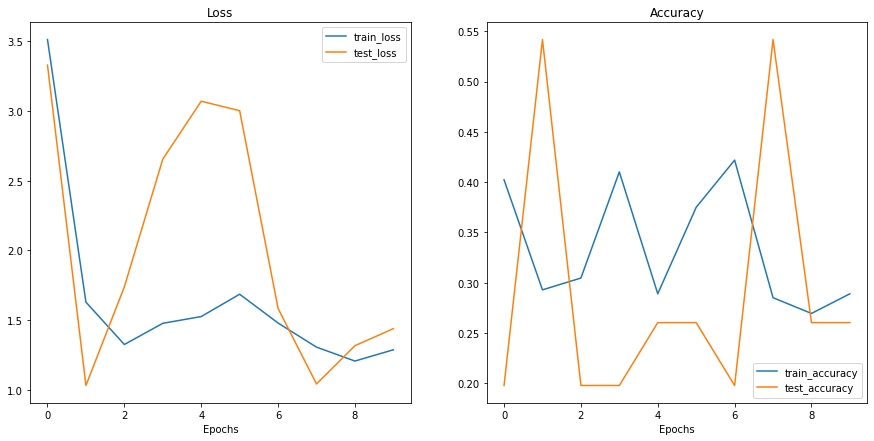

In [ ]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

In [ ]:
pretrained_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_weights).to(device)

for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

pretrained_vit.heads = nn.Linear(in_features=D, out_features=len(class_names)).to(device)
pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_att

In [ ]:
pretrained_vit_transforms = pretrained_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580

In [ ]:
optimizer=torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)

pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6988 | train_acc: 0.7812 | test_loss: 0.4629 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.2883 | train_acc: 0.9453 | test_loss: 0.2781 | test_acc: 0.9280
Epoch: 3 | train_loss: 0.2462 | train_acc: 0.9609 | test_loss: 0.2482 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.1592 | train_acc: 0.9609 | test_loss: 0.2870 | test_acc: 0.8987
Epoch: 5 | train_loss: 0.1638 | train_acc: 0.9688 | test_loss: 0.2615 | test_acc: 0.8987
Epoch: 6 | train_loss: 0.1128 | train_acc: 0.9766 | test_loss: 0.2004 | test_acc: 0.9384
Epoch: 7 | train_loss: 0.1032 | train_acc: 0.9805 | test_loss: 0.1825 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.0900 | train_acc: 0.9805 | test_loss: 0.1894 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.0771 | train_acc: 0.9844 | test_loss: 0.1981 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0873 | train_acc: 0.9883 | test_loss: 0.1988 | test_acc: 0.9384


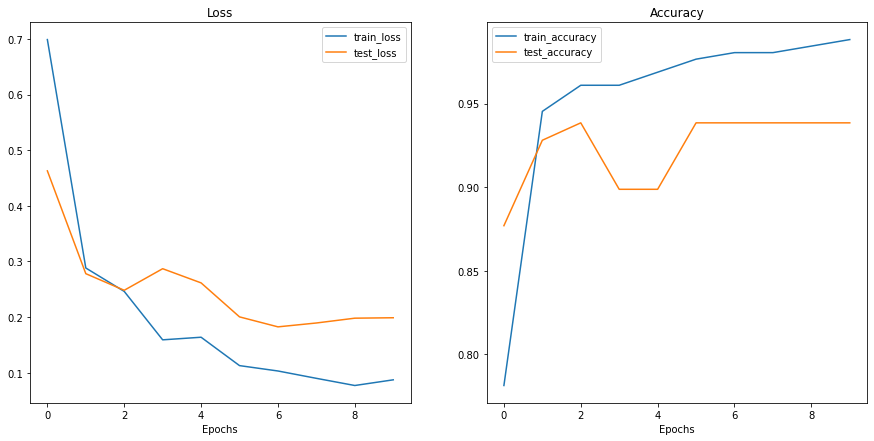

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [ ]:
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="pretrained_vit_pizza_steak_sushi.pth")

[INFO] Saving model to: models/pretrained_vit_pizza_steak_sushi.pth


In [ ]:
import requests
from pathlib import Path

# Setup custom image path
custom_image_path = Path("/content/DALLE-comida1.png")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://github.com/DanteNoguez/intro-ai/raw/main/img/DALLE-comida1.png")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

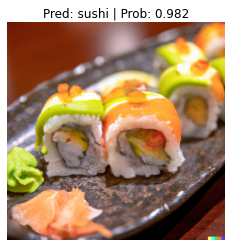

In [ ]:
from going_modular.going_modular.predictions import pred_and_plot_image

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)